## Analysis of A/B test results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project is focused on the subject of A/B testing, a popular user experience research methodology. The goal is to evaluate two versions of an e-commerce website in terms of their user conversion rate. For this purpose, two-sample hypothesis testing is employed. In the end, it is assessed whether the new website leads to more customers.


<a id='probability'></a>
#### Part I - Probability


In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Gather the experiment data and print out the first ten rows.

In [2]:
# Read in dataframe and display the ten first rows
df = pd.read_csv("ab_data.csv")
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print("Number of (rows,columns) in the dataset:", df.shape)

Number of (rows,columns) in the dataset: (294478, 5)


c. The number of unique users in the dataset.

In [4]:
print("Number of unique users in the dataset:", df.user_id.nunique())

Number of unique users in the dataset: 290584


d. The proportion of users converted.

In [5]:
no_users = df.user_id.nunique()
no_users_converted = df.query("converted == 1").user_id.nunique()
print("Proportion of users converted:", no_users_converted/no_users)

Proportion of users converted: 0.12104245244060237


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# Query all records in which new_page and treatment do not line up
a = df.query("(group == 'treatment' and landing_page == 'old_page') or (group == 'control' and landing_page == 'new_page')").shape[0]
print("The requested number of times is:", a)

The requested number of times is: 3893


f. Do any of the rows have missing values?

In [7]:
# Check for missing values
df.info()
print("There are", df.isnull().values.sum(), "rows with missing values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
There are 0 rows with missing values


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Use the answer to the course quiz to create a new dataset that meets the specifications from the quiz.  Store the new dataframe in **df2**.

In [8]:
# Remove the rows where treatment is not aligned with new_page or control is not aligned with old_page
# Proceed with selecting only rows where treatment corresponds to new_page and control to old_page
df2 = df[((df.group == "treatment")&(df.landing_page == "new_page"))|((df.group == "control")&(df.landing_page == "old_page"))]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer relevant questions.

a. How many unique **user_id**s are in **df2**?

In [10]:
print("Number of unique users in the dataset:", df.user_id.nunique())

Number of unique users in the dataset: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]
print("The repeated user_id is 773192")

The repeated user_id is 773192


c. What is the row information for the repeat **user_id**? 

In [12]:
# Display rows of duplicate user_id
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Remove row with index 2893
df2 = df2.drop(2893).reset_index(drop=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
print("The probability is 0.119597")
# Use groupby statement to calculate probabilities
df2.groupby("converted").count()/len(df2)

The probability is 0.119597


,user_id,timestamp,group,landing_page
converted,,,,
0,0.880403,0.880403,0.880403,0.880403
1,0.119597,0.119597,0.119597,0.119597


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
print("The probability is 0.120386")
df2.groupby(["group", "converted",]).count()/len(df2[df2.group == "control"])

The probability is 0.120386


user_id  timestamp  landing_page
group     converted                                   
control   0          0.879614   0.879614      0.879614
          1          0.120386   0.120386      0.120386
treatment 0          0.881410   0.881410      0.881410
          1          0.118838   0.118838      0.118838

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
print("The probability is 0.118808")
df2.groupby(["group", "converted"]).count()/len(df2[df2.group == "treatment"])

The probability is 0.118808


user_id  timestamp  landing_page
group     converted                                   
control   0          0.879396   0.879396      0.879396
          1          0.120356   0.120356      0.120356
treatment 0          0.881192   0.881192      0.881192
          1          0.118808   0.118808      0.118808

d. What is the probability that an individual received the new page?

In [17]:
print("The probability is 0.500062")
df2.groupby(["landing_page"]).count()/len(df2)

The probability is 0.500062


,user_id,timestamp,group,converted
landing_page,,,,
new_page,0.500062,0.500062,0.500062,0.500062
old_page,0.499938,0.499938,0.499938,0.499938


Overall, an individual converted on average with 11.96% regardless of the page. Having received the old page, the conversion rate in the control group was roughly 12.04%. For the individuals seeing the new page, who make up half of the participants in the study, the conversion rate was slightly lower with 11.88%. Hence, the percentage of converted individuals is almost the same in both groups, though it is 0.16 percentage points smaller for the treatment group, indicating that we cannot see sufficient evidence to say that the new page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: **$p_{new}$** <= **$p_{old}$** The average conversion rate for the old page is at least as high as for the new page. 

H1: **$p_{new}$** > **$p_{old}$** The average conversion rate for the new page is higher than for the old one.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
print("The probability is approximately 0.1196")
# Conversion rate regardless of page
df2.groupby("converted").count()/len(df2)

The probability is approximately 0.1196


,user_id,timestamp,group,landing_page
converted,,,,
0,0.880403,0.880403,0.880403,0.880403
1,0.119597,0.119597,0.119597,0.119597


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
print("The probability is approximately 0.1196")
# Conversion rate regardless of page
df2.groupby("converted").count()/len(df2)

The probability is approximately 0.1196


,user_id,timestamp,group,landing_page
converted,,,,
0,0.880403,0.880403,0.880403,0.880403
1,0.119597,0.119597,0.119597,0.119597


In [20]:
# Store p_new and p_old rates under null
p_new = p_old = df2['converted'].mean()

c. What is $n_{new}$?

In [21]:
# Get sample size equal to the ones above and round results to integers
n_new = round(0.500062*len(df2))
n_old = round(0.499938*len(df2))
print("n_new is:", n_new)

n_new is: 145310


d. What is $n_{old}$?

In [22]:
print("n_old is:", n_old)

n_old is: 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# Simulate n_new transactions with conversion rate of p_new with binomial
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# Simulate n_old transactions with conversion rate of p_old with binomial
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
# Determine observed difference between the mean conversion rates
df_new_page_cr = df2[df2.landing_page == "new_page"].converted.mean()
df_old_page_cr = df2[df2.landing_page == "old_page"].converted.mean()
obs_diff = df_new_page_cr - df_old_page_cr
print(obs_diff)

-0.0015782389853555567


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
# Simulation loop that runs 10,000 times
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff) # Append computed difference in conversion rates

p_diffs = np.asarray(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

The histogram of the sampling distribution is in accordance with initial expectations and the central limit theorem, as the sample means of the 10,000 simulations are approximately normally distributed.

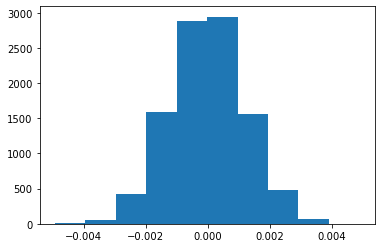

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Proportion of p_diffs that are bigger than observed difference
p_value = (p_diffs > obs_diff).mean()
print("The corresponding value is:", p_value)

The corresponding value is: 0.9044


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The computed value is called p-value. It represents the probability of obtaining the actual observed difference under the assumption that the null hypothesis is true. In this case, the p-value is 0.9005 and thus much bigger than the alpha-level of 5%. That is why we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2.landing_page == "old_page"].shape[0]
n_new = df2[df2.landing_page == "new_page"].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = "larger")
print("z-value:",stat,"p-value:", pval)

z-value: -1.394390551291367 p-value: 0.9184001500898661


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score (-1.39) and p-value (0.92) are numerically in line with the previous results, and they confirm that the conversion rate of the new page is not significantly better than the old one. From a practical viewpoint, the company should keep the current landing page as it is.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

In order to predict a dependent variable which is dichotomous, logistic regression is the appropriate regression technique instead of a conventional linear regression model.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
# Create column for intercept
df2["intercept"] = 1
# Map control and treatment to binary vector for ab_page column
df2["ab_page"] = df2.group.map({'control': '0', 'treatment': '1'}).astype("int")

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [32]:
# Fit logistic regression model using two variables from b.
log_model = sm.Logit(df2.converted, df2[["intercept", "ab_page"]])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:06:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

The p-value associated with ab_page has a different interpretation because it refers to the significance of the coefficient of ab_page in the model rather than the significance of an observed difference in conversion rates like in Part II. In the case of the model, the coefficient is not statistically signficiant and thus differs not significantly from 0.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding extra variables can improve the model, since additional variables may help to better explain the variance of the dependent variable. However, when the added variables are highly correlated with other independent variables (multicollinearity) or do not assist in explaining the variance of the dependent variable, they might weaken the model's performance.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [34]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [35]:
# Create the necessary dummy variables
df_new[["CA", "UK", "US"]] = pd.get_dummies(df_new.country)
# Fit logistic regression model
log_model = sm.Logit(df_new.converted, df_new[["intercept", "ab_page", "CA", "UK"]])
results = log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        20:06:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

According to the model summary above, the coefficients for the country variables (CA and UK) are close to zero. Moreover, they are both not significant with p-values > 0.05. Consequently, there is no evidence that countries have an impact on the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [36]:
# Create the interaction variables
df_new['uk_abpage'] = df_new["ab_page"]*df_new["UK"]
df_new['us_abpage'] = df_new["ab_page"]*df_new["US"]
df_new['ca_abpage'] = df_new["ab_page"]*df_new["CA"]
# Fit logistic regression model
log_model = sm.Logit(df_new.converted, df_new[["intercept", "ab_page", "CA", "UK", "ca_abpage", "uk_abpage"]])
results = log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 09 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        20:06:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ca_abpage     -0.0469      0.054     -0.872      0.383      -0.152       0.059
uk_abpage      0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Finally, as it was the case with country variables, the higher order interaction terms between country and page do not elicit a significant effect on the conversion rate. Their p-values are way higher than the previously set significance level of 5%.